# TM10007 Assignment template -- ECG data

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [1]:
# Run this to use from colab environment

import zipfile
import os
import pandas as pd

#with zipfile.ZipFile('ecg_data.zip', 'r') as zip_ref: #TODO: let hierop voor inleveren
#    zip_ref.extractall('ecg')

data = pd.read_csv('ecg/ecg_data.csv', index_col=0)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

The number of samples: 827
The number of columns: 9001


T-TESTING

Below I tried to find ways to separate our data in classes based on the features. 

First, the p-values for all features were determined to find the features with the highest significant difference between the classes. These are visualised. The 2 features with the lowest p-value were plotted against eachother in a scatterplot, but showed no seperability between the classes. 

Secondly, a PCA was performed. 

     feature    t_stat       p_value
3814    5_64  6.728289  6.223523e-11
3831    5_81  6.776686  6.728404e-11
64      0_64  6.156559  1.866903e-09
90      0_90  6.155961  1.954069e-09
81      0_81  6.149412  2.037904e-09
...      ...       ...           ...
2120   2_620  0.002408  9.980796e-01
7727  10_227 -0.001911  9.984767e-01
4656   6_156  0.001856  9.985215e-01
1805   2_305  0.000842  9.993290e-01
1355   1_605 -0.000639  9.994905e-01

[9000 rows x 3 columns]
Number of features with p-value < 0.05: 1204


C:\Users\20ast\AppData\Local\Temp\ipykernel_17200\526442904.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


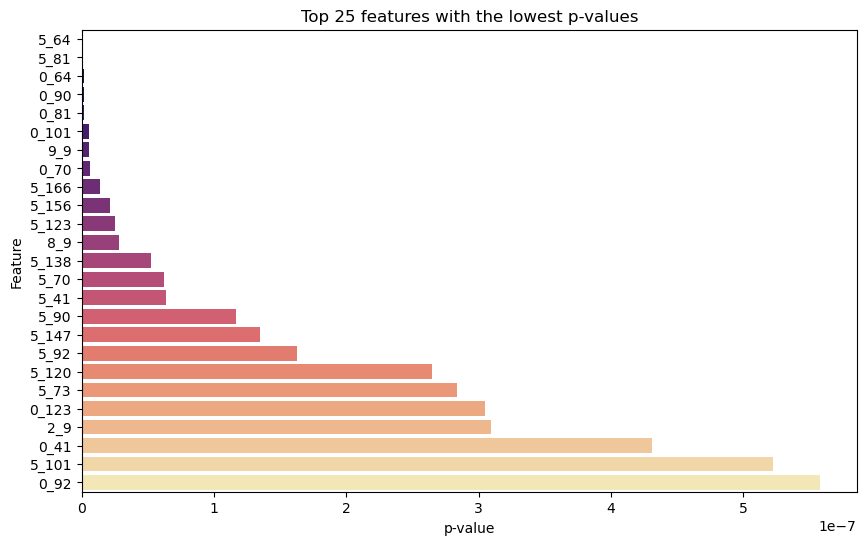

The features with the lowest p-values are: 5_64 and 5_81


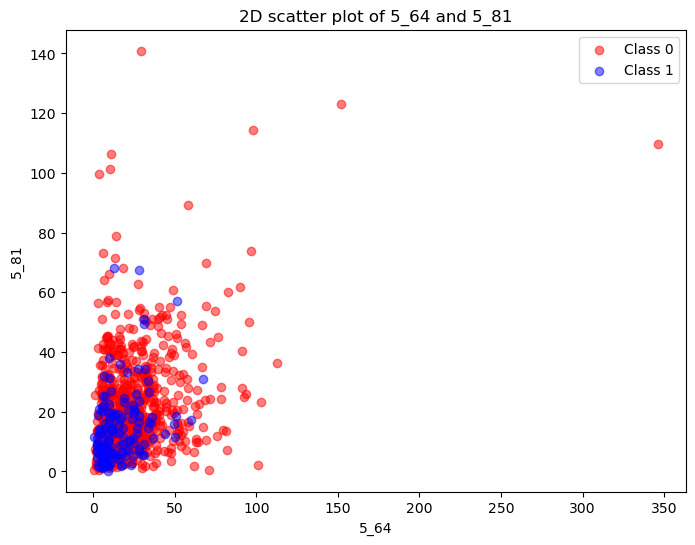

In [41]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

# print(data.head())

# Split data by class
class0 = data[data['label'] == 0]
class1 = data[data['label'] == 1]

features = data.drop(columns=['label'])

# Remove the 'label' column before performing t-tests
class0 = class0.drop(columns=['label']) 
class1 = class1.drop(columns=['label'])

# Perform t-test for each feature
t_stats, p_values = ttest_ind(class0, class1, axis=0, equal_var=False)

# Create a DataFrame to store the results
results = pd.DataFrame({'feature': data.columns[:-1],
                        't_stat': t_stats,
                        'p_value': p_values})

# Sort the results by p-value
results_sorted = results.sort_values('p_value')
print(results_sorted)
p_below_0_05 = results_sorted[results_sorted['p_value'] < 0.05]
print(f'Number of features with p-value < 0.05: {len(p_below_0_05)}')

# Save significant features to a CSV file
significant_feature_names = p_below_0_05['feature']
significant_features = data[significant_feature_names]
cleaned_features = significant_feature_names.str.replace(r'^.*_', '', regex=True)
cleaned_features = cleaned_features.sort_values()


cleaned_features.to_csv('significant_features.csv', index=False)


n = 25
top_features = results_sorted.head(n)
plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_features['p_value'],
    y=top_features['feature'],
    palette='magma'
)
plt.xlabel('p-value')
plt.ylabel('Feature')
plt.title(f'Top {n} features with the lowest p-values')
plt.show()

best_features = results_sorted['feature'].head(2).values
feat1, feat2 = best_features
print(f'The features with the lowest p-values are: {feat1} and {feat2}')
plot_data = data[[feat1, feat2, 'label']]

plt.figure(figsize=(8,6))
colors = {0: 'red', 1: 'blue'}

for label in plot_data['label'].unique():
    subset = plot_data[plot_data['label'] == label]
    plt.scatter(subset[feat1], subset[feat2], c=colors[label], label=f'Class {label}', alpha=0.5)

plt.xlabel(feat1)
plt.ylabel(feat2)
plt.title(f'2D scatter plot of {feat1} and {feat2}')
plt.legend()
plt.show()


PCA ANALYSIS

Below, a PCA analysis was performed to improve class separation with dimensionality reduction. PCA shows directions of highest variance, which mat help find structure in the classes and separation of these classes. 

In the scatter plot, each dot is a sample. The x and y axis contain new features (PC1 en PC2) that represent directions of maximum variance in the data. If the classes are clustered seperately (they are not), it means PCA captured some separability. 

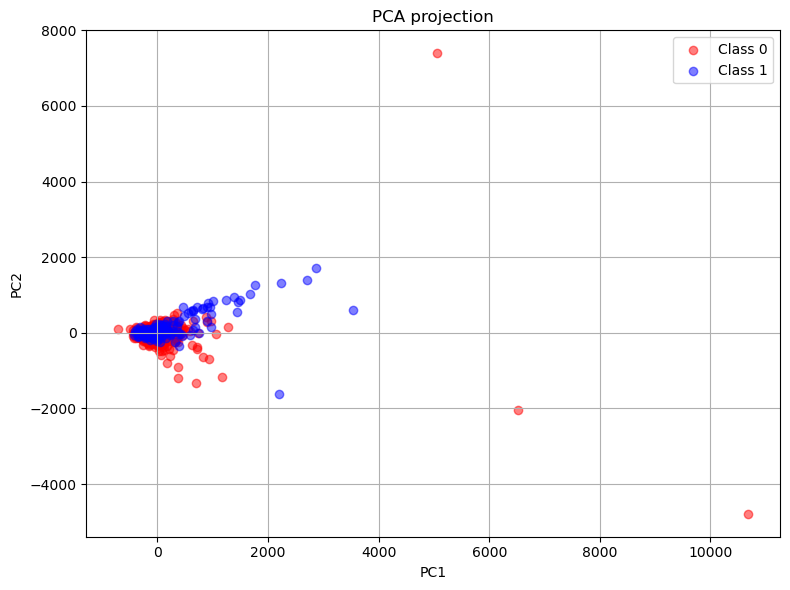

In [40]:
from sklearn.decomposition import PCA

y = data['label'].values

pca = PCA(n_components=2)
x_pca = pca.fit_transform(significant_features)

plt.figure(figsize=(8,6))
plt.scatter(x_pca[y == 0, 0], x_pca[y == 0, 1], c='red', label='Class 0', alpha=0.5)
plt.scatter(x_pca[y == 1, 0], x_pca[y == 1, 1], c='blue', label='Class 1', alpha=0.5)
plt.title('PCA projection')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The plot above shows overlap in classes. This can mean that the directions of highest variance (which PCA uses) are not aligned with the directions that best separate the classes.If the most 'spread-out' directions in the data don't correspond to differences between class 0 and 1, PCA might not reveal any separation. 

Next, I'll try supervised dimensionaltiy reduction with linear discriminant analysis. 

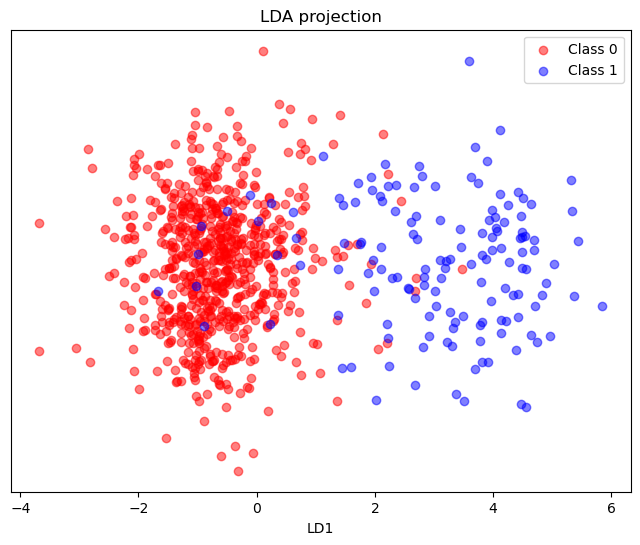

In [45]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=1)
x_lda = lda.fit_transform(features, y) 

y_scatter = np.random.normal(0, 0.02, size=len(x_lda))

plt.figure(figsize=(8,6))
plt.scatter(x_lda[y == 0], y_scatter[y == 0], color='red', alpha=0.5, label='Class 0')
plt.scatter(x_lda[y == 1], y_scatter[y == 1], color='blue', alpha=0.5, label='Class 1')
plt.title('LDA projection')
plt.xlabel('LD1')
plt.yticks([])
plt.legend()
plt.show()

LDA is a supervised dimensionality reduction technique. It knwos the class labels and tries to find the directions (linear combinations of features) that best separate the classes. LDA tries to maximize between-class variance (spread the class means apart) and minimize within-class variance (keep samples from the same class as close as possible). 

For c classes and n features, LDA reduces the data to a most c-1 dimensions. For 2 classes, LDA gives 1 component, resulting in a 1D projection. 

LDA can be used for labelled data to see class separability and often improves classification performance with reducing dimensionality. 

LDA might not help much if the classes are not linearly separable or if the features are not normally distributed or have unequal covariances. 

To check whether the covariance between classes are equal, I compared covariance matrices. This is important because a core assumption of LDA is equal covariance between classes. 

The covariance matrix measures how features in the dataset move together. The matrix tells how each feature varies on its own (the diagonal) and how pairs of features change together (the off-diagonal). The covariances on the diagonal are therefore actually variances of one features (how much it varies from its mean). 

In [23]:
n_features = 9001
cov0 = np.cov(class0.iloc[:, :n_features], rowvar=False)
cov1 = np.cov(class1.iloc[:, :n_features], rowvar=False)

cov_diff = np.abs(cov0 - cov1)
print(f"Mean absolute difference between covariance matrices: {np.mean(cov_diff)}")


Mean absolute difference between covariance matrices: 32.98255583485797


This mean absolute difference shows a mismatch between the covariance matrices. LDA is therefore not suitable. 

Next, I'll try QDA since this method doesn't assume equal covariances

c:\Users\20ast\miniconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


QDA accuray: 0.45180722891566266

 Clasdification report:
               precision    recall  f1-score   support

           0       0.83      0.43      0.56       138
           1       0.17      0.57      0.26        28

    accuracy                           0.45       166
   macro avg       0.50      0.50      0.41       166
weighted avg       0.72      0.45      0.51       166


 Confusion matrix:
 [[59 79]
 [12 16]]


c:\Users\20ast\miniconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


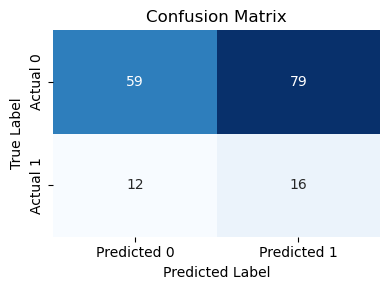

In [86]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

x_train, x_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)
qda = QDA()
qda.fit(x_train, y_train)
y_pred = qda.predict(x_test)

print(f"QDA accuray: {accuracy_score(y_test, y_pred)}")
print("\n Clasdification report:\n", classification_report(y_test, y_pred))
print("\n Confusion matrix:\n", confusion_matrix(y_test, y_pred))

def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_test, y_pred)

The overall accuracy can be misleading if the classes are imbalanced! That means a lot more samples in one class compared to the other. The model can then achieve a high accuracy by just favoring the class with the most samples (which it does, resulting in low precision and recall for class 1). 

Confusion matrix: [[true negatives false positives]
                    [false negatives true positives]]

High dimensionality: QDA overfits to class 0 because of the large number of features and relatively few class 1 samples. To fix this, I'll select the most relevant features using a supervised scoring function. 

QDA Accuracy: 0.8373493975903614

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.99      0.91       138
           1       0.67      0.07      0.13        28

    accuracy                           0.84       166
   macro avg       0.75      0.53      0.52       166
weighted avg       0.81      0.84      0.78       166


Confusion Matrix:
 [[137   1]
 [ 26   2]]


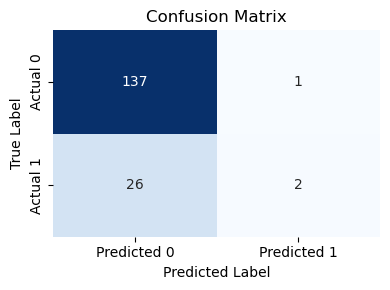

In [87]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
k=100

selector = SelectKBest(score_func=mutual_info_classif, k=k)
x_selected = selector.fit_transform(features, y)
selected_feature_names = features.columns[selector.get_support()]

x_train, x_test, y_train, y_test = train_test_split(x_selected, y, test_size=0.2, random_state=42)

qda = QDA()
qda.fit(x_train, y_train)
y_pred = qda.predict(x_test)

print("QDA Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

plot_confusion_matrix(y_test, y_pred)

QDA still doesn't work, not even after feature selection. This means the model is still biased towards class 0. QDA can't handle class imbalance well, so next I'll try a model that can handle imbalance: Random Forest, SVM or Logistic Regression. 

Random Forest Accuracy: 0.8734939759036144

Classification Report:
               precision    recall  f1-score   support

           0       0.87      1.00      0.93       138
           1       1.00      0.25      0.40        28

    accuracy                           0.87       166
   macro avg       0.93      0.62      0.66       166
weighted avg       0.89      0.87      0.84       166


Confusion Matrix:
 [[138   0]
 [ 21   7]]


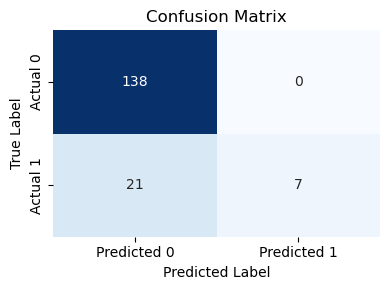

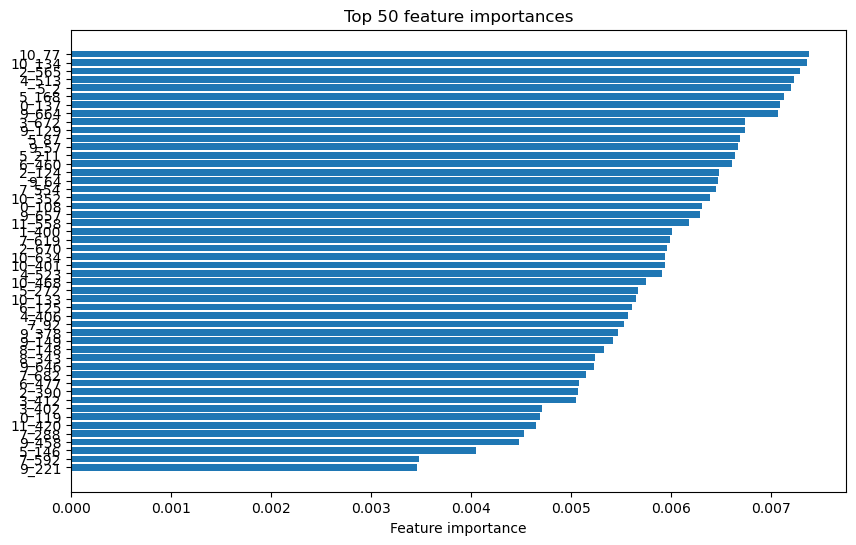

In [88]:
# Random forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, class_weight = 'balanced', random_state=42)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

plot_confusion_matrix(y_test, y_pred)

# Plot top featyre importances
importances = rf.feature_importances_
feature_names = features.columns[selector.get_support()]
indices = np.argsort(importances)[::1]
top_k = 50

plt.figure(figsize=(10, 6))
plt.barh(range(top_k), importances[indices[:top_k]], align='center')
plt.yticks(range(top_k), feature_names[indices[:top_k]])
plt.xlabel('Feature importance')
plt.title(f'Top {top_k} feature importances')
plt.show()

The feature imprtance measures how much a feature contributes to reducing uncertainty (impurity) across all the trees in the forest. Each tree splits the data based on certain features. Each time a feature is used to make a split, the Gini impurity gets reduced. The importance of a feature is the sum of all impurity reductions it contributes across all trees in the forest. 
High feature importance means the feature is frequently used in splits. 

In high-dimensional data (like ours), feature importance can help prune down to the truly useful stuff. 

We can use the top N important features. 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Accuracy: 0.7951807228915663

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.82      0.87       138
           1       0.43      0.68      0.53        28

    accuracy                           0.80       166
   macro avg       0.68      0.75      0.70       166
weighted avg       0.84      0.80      0.81       166


Confusion Matrix:
 [[113  25]
 [  9  19]]


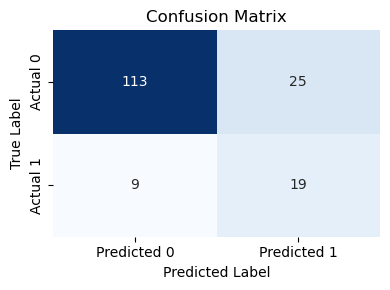

In [ ]:
from sklearn.model_selection import GridSearchCV

# Select top k features
top_k = 100
top_indices = np.argsort(importances)[:top_k] 
top_feature_names = feature_names[top_indices]
x_top = features[top_feature_names]

# Split data
x_train, x_test, y_train, y_test = train_test_split(x_top, y, test_size=0.2, random_state=42)

# Tune hyperparameters
param_grid = {
    'n_estimators': [200, 150, 250], # number of trees, more trees is more stable model
    'max_depth': [None, 1, 2, 10, 20], # maximum tree depth, shallower trees (10-20) are less prone to overfitting
    'min_samples_split': [2, 3, 4], # minimum number of samples required to split an internal node
    'min_samples_leaf': [4, 3, 5], # minimum samples required to be at a leaf node
    'max_features': ['sqrt'], # number of features to consider when looking for the best split
    'class_weight': ['balanced'] # handles imbalanced classes
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)
grid.fit(x_train, y_train)
print("Best parameters:", grid.best_params_)

# Use best model from GridSearch
best_rf = grid.best_estimator_

# Predict probabilities
y_proba = best_rf.predict_proba(x_test)[:, 1]
threshold = 0.3 # set a thershold for predictiing class 1, default is 0.5
y_pred_adjusted = (y_proba >= threshold).astype(int)

# Evaluation 
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_adjusted))
print("\nClassification Report:\n", classification_report(y_test, y_pred_adjusted))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_adjusted))

plot_confusion_matrix(y_test, y_pred_adjusted)
